# Frequentist Inference Case Study - Part B

## Learning objectives

Welcome to Part B of the Frequentist inference case study! The purpose of this case study is to help you apply the concepts associated with Frequentist inference in Python. In particular, you'll practice writing Python code to apply the following statistical concepts: 
* the _z_-statistic
* the _t_-statistic
* the difference and relationship between the two
* the Central Limit Theorem, including its assumptions and consequences
* how to estimate the population mean and standard deviation from a sample
* the concept of a sampling distribution of a test statistic, particularly for the mean
* how to combine these concepts to calculate a confidence interval

In the previous notebook, we used only data from a known normal distribution. **You'll now tackle real data, rather than simulated data, and answer some relevant real-world business problems using the data.**

## Hospital medical charges

Imagine that a hospital has hired you as their data scientist. An administrator is working on the hospital's business operations plan and needs you to help them answer some business questions. 

In this assignment notebook, you're going to use frequentist statistical inference on a data sample to answer the questions:
* has the hospital's revenue stream fallen below a key threshold?
* are patients with insurance really charged different amounts than those without?

Answering that last question with a frequentist approach makes some assumptions, and requires some knowledge, about the two groups.

We are going to use some data on medical charges obtained from [Kaggle](https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset). 

For the purposes of this exercise, assume the observations are the result of random sampling from our single hospital. Recall that in the previous assignment, we introduced the Central Limit Theorem (CLT), and its consequence that the distributions of sample statistics approach a normal distribution as $n$ increases. The amazing thing about this is that it applies to the sampling distributions of statistics that have been calculated from even highly non-normal distributions of data! Recall, also, that hypothesis testing is very much based on making inferences about such sample statistics. You're going to rely heavily on the CLT to apply frequentist (parametric) tests to answer the questions in this notebook.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.stats import norm
from numpy.random import seed
medical = pd.read_csv('insurance2.csv')

In [3]:
medical.shape

(1338, 8)

In [4]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


__Q1:__ Plot the histogram of charges and calculate the mean and standard deviation. Comment on the appropriateness of these statistics for the data.

__A:__ The histogram shows that the charge is not normally distributed and has a high variance in one direction.  There are also some very high numbers which might be outliers, and these are pulling the mean up, indicated by how much higher the mean is than the median.  The standard deviation is also larger than the median and almost as large as the mean, making it not particluarly informative.

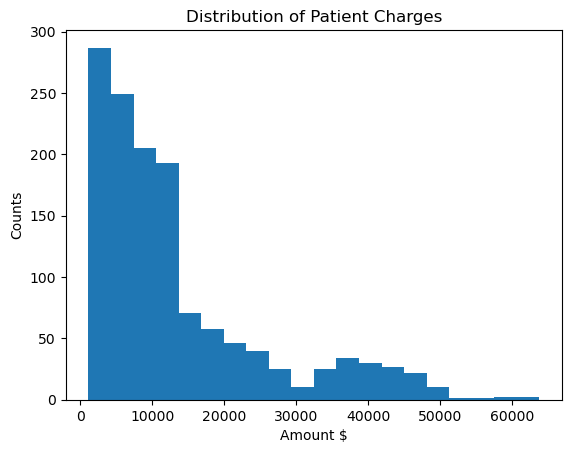

In [5]:
plt.hist(medical['charges'], bins=20)
plt.title('Distribution of Patient Charges')
plt.xlabel('Amount $')
plt.ylabel('Counts')
plt.show()

In [6]:
medical_mean = np.mean(medical['charges'])
medical_std = np.std(medical['charges'])
medical_std_pop = np.std(medical['charges'], ddof=1)
print(medical_mean, medical_std, medical_std_pop)

13270.422265141257 12105.484975561605 12110.011236693994


In [7]:
medical_median = np.median(medical['charges'])
medical_median

np.float64(9382.033)

__Q2:__ The administrator is concerned that the actual average charge has fallen below 12,000, threatening the hospital's operational model. On the assumption that these data represent a random sample of charges, how would you justify that these data allow you to answer that question? And what would be the most appropriate frequentist test, of the ones discussed so far, to apply?

__A:__  I would answer this question using bootstrapping with replacement.  We could then do a distribution of the population mean with 95% confidence intervals to get a more accurate idea of the true mean and whether it has falled below 12,000$.

__Q3:__ Given the nature of the administrator's concern, what is the appropriate confidence interval in this case? A ***one-sided*** or ***two-sided*** interval? (Refresh your understanding of this concept on p. 399 of the *AoS*). Calculate the critical value and the relevant 95% confidence interval for the mean, and comment on whether the administrator should be concerned.

__A:__

In [8]:
#For example, lets sample 1000 charges 10000 times
def medical_bootstrap(n, size):
    return [np.mean(np.random.choice(medical['charges'], n)) for _ in range(size)]
bootstrap = medical_bootstrap(1000, 10000)
bootstrap_mean = np.mean(bootstrap)
bootstrap_std = np.std(bootstrap, ddof=1)

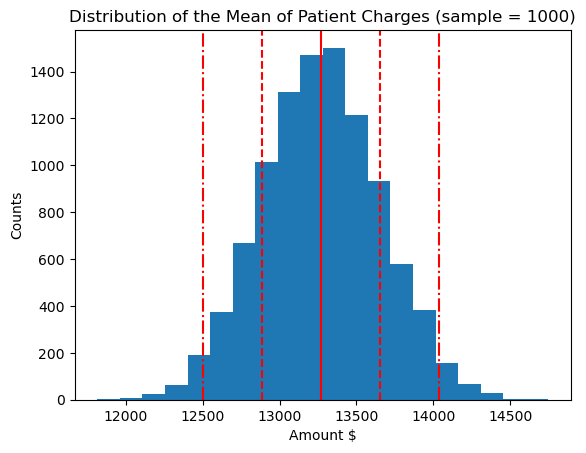

In [9]:
#Plot the mean of the bootstrapping with quartiles amrked by lines
_ = plt.hist(bootstrap, bins=20)
_ = plt.title('Distribution of the Mean of Patient Charges (sample = 1000)')
_ = plt.xlabel('Amount $')
_ = plt.ylabel('Counts')
_ = plt.axvline(bootstrap_mean, color='r')
_ = plt.axvline(bootstrap_mean+bootstrap_std, color='r', linestyle='--')
_ = plt.axvline(bootstrap_mean-bootstrap_std, color='r', linestyle='--')
_ = plt.axvline(bootstrap_mean+bootstrap_std*2, color='r', linestyle='-.')
_ = plt.axvline(bootstrap_mean-bootstrap_std*2, color='r', linestyle='-.')
plt.show()

In [10]:
#Calculate 95% confidence intervals based on an assumption of normality
z_value = norm.ppf(1-.05/2)
error_95 = z_value*bootstrap_std
ci_lower = bootstrap_mean-error_95
ci_upper = bootstrap_mean+error_95
print(f'The 95% confidence interval based on an assumption of normality goes from {ci_lower:.2f}$ to {ci_upper:.2f}$.')

The 95% confidence interval based on an assumption of normality goes from 12518.16$ to 14022.35$.


In [11]:
#Calculate 95% confidence intervals based on percentiles
ci_percentile_upper, ci_percentile_lower = np.percentile(bootstrap, [2.5, 97.5])
print(f'The 95% confidence interval based on percentiles goes from {ci_percentile_upper:.2f}$ to {ci_percentile_lower:.2f}$.')

The 95% confidence interval based on percentiles goes from 12529.29$ to 14020.03$.


In both cases, the confidence interval does not include 12,000$, indicating that the administrator has no cause for concern.

The administrator then wants to know whether people with insurance really are charged a different amount to those without.

__Q4:__ State the null and alternative hypothesis here. Use the _t_-test for the difference between means, where the pooled standard deviation of the two groups is given by:
\begin{equation}
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

and the *t*-test statistic is then given by:

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}

(If you need some reminding of the general definition of ***t-statistic***, check out the definition on p. 404 of *AoS*). 

What assumption about the variances of the two groups are we making here?

__A:__  The Null Hypothesis is that there is no difference between the charges for insured and uninsured patients.  The Alternative Hypothesis is that the charge is different between insured and uninsured patients.  We are assuming that the insured and uninsured populations have the same (or similar) variance.

__Q5:__ Perform this hypothesis test both manually, using the above formulae, and then using the appropriate function from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests) (hint, you're looking for a function to perform a _t_-test on two independent samples). For the manual approach, calculate the value of the test statistic and then its probability (the p-value). Verify you get the same results from both.

__A:__ 

In [12]:
# First step is to find the number of samples in each group, or n0 and n1.  I'm assuming that the values in the insuranceclaim column correspond to 1 = Insurance, 0 = No Insurance. 
# To avoid confusion, n0, s0 and x0 will refer to patients without insurance.
n1, n0 = medical['insuranceclaim'].value_counts()
print(f'n0 = {n0}, n1 = {n1}, for the number of charges to patients wihtout and with insurance, respectively.')

n0 = 555, n1 = 783, for the number of charges to patients wihtout and with insurance, respectively.


In [13]:
# Next, calculate the standard deviations for each group as well as the pooled variance, sp.
medical_grouped = medical.groupby('insuranceclaim')['charges'].std()
s0 = medical_grouped[0]
s1 = medical_grouped[1]
sp = np.sqrt(((n0-1)*s0**2 + (n1-1)*s1**2)/(n0 + n1 - 2))
print(f's0 = {s0}, s1 = {s1}, sp = {sp}')

s0 = 6446.510126811733, s1 = 14045.928418802128, sp = 11520.034268775256


In [14]:
# Next find the means of the two groups and perform the t-test.
medical_grouped2 = medical.groupby('insuranceclaim')['charges'].mean()
x0 = medical_grouped2[0]
x1 = medical_grouped2[1]
t_stat = (x0-x1)/(sp*np.sqrt((1/n0)+(1/n1)))
p = 2 * (1 - t.cdf(abs(t_stat), (n0 + n1 - 2)))
print(f'x0 = {x0}, x1 = {x1}, t-statistic = {t_stat}, p-value = {p:.40e}')

x0 = 8821.421892306305, x1 = 16423.928276537677, t-statistic = -11.893299030876715, p-value = 0.0000000000000000000000000000000000000000e+00


P-value is actually `~4.46e-31` but I can't figure out how to get scientific notation to work here.

In [20]:
# Now compute t-stat and p-value in python
from scipy.stats import ttest_ind
insurance = medical[medical['insuranceclaim'] == 1]['charges']
no_insurance = medical[medical['insuranceclaim'] == 0]['charges']
t, p = ttest_ind(no_insurance, insurance, equal_var=True)
print(f't-statistic = {t}, p-value = {p:.2e}')

t-statistic = -11.893299030876712, p-value = 4.46e-31


Congratulations! Hopefully you got the exact same numerical results. This shows that you correctly calculated the numbers by hand. Secondly, you used the correct function and saw that it's much easier to use. All you need to do is pass your data to it.

__Q6:__ Conceptual question: look through the documentation for statistical test functions in scipy.stats. You'll see the above _t_-test for a sample, but can you see an equivalent one for performing a *z*-test from a sample? Comment on your answer.

__A:__  `scipy.stats` has a zscore function that can calculatate individual z-scores for data points which can be used to do a manual z-test, but there is no ztest function.  There is a ztest function in `statsmodels.stats.weightstats` that can be used similar to `ttest_ind` in `scipy.stats`.  A z-test would not have been appropirate for this data since it is not normally distributed.

## Learning outcomes

Having completed this project notebook, you now have good hands-on experience:
* using the central limit theorem to help you apply frequentist techniques to answer questions that pertain to very non-normally distributed data from the real world
* performing inference using such data to answer business questions
* forming a hypothesis and framing the null and alternative hypotheses
* testing this using a _t_-test